inspired by https://github.com/Data-Monkey/GTFS-NetworkX/blob/master/GTFStoGraph.py

GTFS API: https://developers.google.com/transit/gtfs/reference#agencytxt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

### Import the GTFS Files

In [2]:
ROUTES = pd.read_csv('cta_data/routes.txt')
STOPS = pd.read_csv('cta_data/stops.txt')
TRIPS = pd.read_csv('cta_data/trips.txt')
STOP_TIMES = pd.read_csv('cta_data/stop_times.txt')

### Clean the Data for "L" Train info only

We (for now) only want to model subways/metros, which use `route_type=1`, so we get a list of the `route_id`s that correspond ot the subway ("L") lines

In [4]:
ROUTES_subway = ROUTES[ROUTES['route_type']==1]
# record subway route_ids
route_ids_subway = ROUTES_subway['route_id'].values.tolist()
ROUTES_subway

,route_id,route_short_name,route_long_name,route_type,route_url,route_color,route_text_color
126,Red,NaN,Red Line,1,http://www.transitchicago.com/redline/,C60C30,FFFFFF
127,P,NaN,Purple Line,1,http://www.transitchicago.com/purpleline/,522398,FFFFFF
128,Y,NaN,Yellow Line,1,http://www.transitchicago.com/yellowline/,F9E300,000000
129,Blue,NaN,Blue Line,1,http://www.transitchicago.com/blueline/,00A1DE,FFFFFF
130,Pink,NaN,Pink Line,1,http://www.transitchicago.com/pinkline/,E27EA6,FFFFFF
131,G,NaN,Green Line,1,http://www.transitchicago.com/greenline/,009B3A,FFFFFF
132,Org,NaN,Orange Line,1,http://www.transitchicago.com/orangeline/,F9461C,FFFFFF
133,Brn,NaN,Brown Line,1,http://www.transitchicago.com/brownline/,62361B,FFFFFF


Likewise, we will filter the `TRIPS` data so that it only includes trips for subway routes:

In [70]:
# filter to only include trips with subway route_ids
TRIPS_subway = TRIPS[TRIPS['route_id'].isin(route_ids_subway)]

# # only include one direction to avoid redundancies
# TRIPS_subway = TRIPS_subway[TRIPS_subway['direction_id']==1]
trip_ids_subway = list(TRIPS_subway['trip_id'].values)


trip_id_dict = {}

for route_id in route_ids_subway:
    trip_id_dict[route_id] = TRIPS_subway[TRIPS_subway['route_id']==route_id].iloc[0]['trip_id']

trip_id_dict.values()

dict_values([60164372393, 60164283124, 60164283213, 60166141078, 60166141628, 60161923601, 60166204913, 60166204634])

In [71]:
STOP_TIMES_subway = STOP_TIMES[STOP_TIMES['trip_id'].isin(trip_id_dict.values())].reset_index()
STOP_TIMES_subway[STOP_TIMES_subway['pickup_type'] == 0]

,index,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled
0,14608,60161923601,04:00:00,04:00:00,30003,1,Cottage Grove,0,0
1,14609,60161923601,04:02:00,04:02:00,30263,2,Cottage Grove,0,2558
2,14610,60161923601,04:03:30,04:03:30,30119,3,Cottage Grove,0,5317
3,14611,60161923601,04:05:00,04:05:00,30243,4,Cottage Grove,0,7912
4,14612,60161923601,04:06:30,04:06:30,30054,5,Cottage Grove,0,10223
...,...,...,...,...,...,...,...,...,...
209,136359,60166204913,04:14:00,04:14:00,30023,20,Midway,0,90716
210,136360,60166204913,04:18:00,04:18:00,30061,21,Midway,0,101776
211,136361,60166204913,04:20:00,04:20:00,30220,22,Midway,0,107300
212,136362,60166204913,04:22:00,04:22:00,30186,23,Midway,0,113177


We only want to track `stations` (`location_type=1`), but `STOP_TIMES` gives information for `platforms`(`location_type=0`). So first we need to assign the parent for each of the stops in `STOP_TIMES`

In [72]:
STOPS_stations = STOPS[STOPS['location_type']==1]
# stop_ids_stations = list(STOPS_stations['stop_id'].unique())

In [73]:
def get_parent(stop_id):
    parent = STOPS[STOPS['stop_id']==stop_id]['parent_station'].values
    if len(parent) == 0:
        return stop_id
    else:
        return int(parent[0])

STOP_TIMES_subway['station_id'] = STOP_TIMES_subway['stop_id'].apply(get_parent)

In [74]:
STOP_TIMES_subway

,index,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled,station_id
0,14608,60161923601,04:00:00,04:00:00,30003,1,Cottage Grove,0,0,40020
1,14609,60161923601,04:02:00,04:02:00,30263,2,Cottage Grove,0,2558,41350
2,14610,60161923601,04:03:30,04:03:30,30119,3,Cottage Grove,0,5317,40610
3,14611,60161923601,04:05:00,04:05:00,30243,4,Cottage Grove,0,7912,41260
4,14612,60161923601,04:06:30,04:06:30,30054,5,Cottage Grove,0,10223,40280
...,...,...,...,...,...,...,...,...,...,...
209,136359,60166204913,04:14:00,04:14:00,30023,20,Midway,0,90716,40120
210,136360,60166204913,04:18:00,04:18:00,30061,21,Midway,0,101776,40310
211,136361,60166204913,04:20:00,04:20:00,30220,22,Midway,0,107300,41150
212,136362,60166204913,04:22:00,04:22:00,30186,23,Midway,0,113177,40960


### use trip information to determine graph edges

In [75]:
origin_stops = []
dest_stops = []
trip_ids = []

edges_list = []

for trip_id, group in STOP_TIMES_subway.groupby('trip_id'):
        for i in group.index[:-1]:
            origin_stop = STOP_TIMES_subway['station_id'][i]
    #         print(i)
            dest_stop = STOP_TIMES_subway['station_id'][i+1]
            if (STOP_TIMES_subway['stop_sequence'][i+1] - STOP_TIMES_subway['stop_sequence'][i]) == 1:
                origin_stops.append(origin_stop)
                dest_stops.append(dest_stop)
                trip_ids.append(trip_id)
                edges_list.append((origin_stop, dest_stop))

In [76]:
len(STOP_TIMES_subway['trip_id'].unique())

8

In [77]:
edges = pd.DataFrame({'origin_stop':origin_stops, 'dest_stop':dest_stops, 'trip_id':trip_ids})
edges

,origin_stop,dest_stop,trip_id
0,40020,41350,60161923601
1,41350,40610,60161923601
2,40610,41260,60161923601
3,41260,40280,60161923601
4,40280,40700,60161923601
...,...,...,...
201,41060,40120,60166204913
202,40120,40310,60166204913
203,40310,41150,60166204913
204,41150,40960,60166204913


### Let's play around with just stops data:

In [78]:
l_stops_raw = pd.read_csv("cta_data/CTA_-_System_Information_-_List_of__L__Stops_-_Map.csv")
# convert coords to a readable dict
locations = l_stops_raw.Location.apply(lambda x: x[1:-1].split(","))
coords = pd.DataFrame(locations.tolist(), columns=['lat', 'long']).astype('float')

l_stops = l_stops_raw.drop(['Location'], axis=1)
l_stops = l_stops.join(coords)

In [79]:
l_stops['STATION_ID'] = l_stops['STOP_ID'].apply(get_parent)

In [80]:
# read in stop colors
stop_colors = l_stops[['STATION_ID', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y','Pnk', 'O']]

color_conversion = {'RED':'red', 'BLUE':'blue', 'G':'green', 'BRN':'brown', 'P':'purple', 'Pexp':'purple', 'Y':'yellow','Pnk':'pink', 'O':'orange'}

colors_dict = {}
for i in stop_colors.index:
    colors_list = []
    for c in stop_colors.columns.astype('str'):
        if stop_colors[c][i] == True:
            colors_list.append(color_conversion[c])
    if len(colors_list) == 0:
        colors_list.append('k')
    colors_dict[l_stops['STATION_ID'][i]] = colors_list

In [81]:
node_coords = {}
for i in coords.index:
    node_coords[l_stops['STATION_ID'][i]] = (coords.iloc[i].long, 
                      coords.iloc[i].lat)

In [82]:
G = nx.Graph()

G.add_edges_from(edges_list)

In [83]:
for n in G.nodes:
    stop_row = STOPS[STOPS['stop_id']==n]
    G.nodes[n]['pos'] = (stop_row['stop_lon'].values[0],
                         stop_row['stop_lat'].values[0])
    G.nodes[n]['node_color'] = colors_dict[n][0]

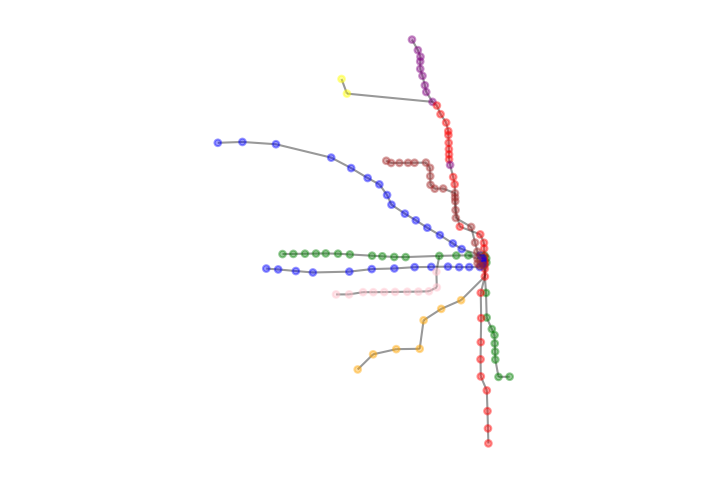

In [84]:
fig, ax = plt.subplots(dpi=150)
nx.draw(G, node_coords, 
        ax=ax, alpha=0.4, 
        node_size=10, 
        node_color=[G.nodes[i]['node_color'] for i in G.nodes])
plt.axis('equal')
plt.grid(which='both')
plt.show()